# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.linalg

#### Part (1)

In [10]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [11]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    # <YOUR CODE>
    u1 = matches[:,0]
    v1 = matches[:,1]
    u2 = matches[:,2]
    v2 = matches[:,3]
    A = np.ones((len(matches), 9))
    for i in range(A.shape[0]):
        A[i] = [u2[i]*u1[i], u2[i]*v1[i], u2[i], v2[i]*u1[i], v2[i]*v1[i], v2[i], u1[i], v1[i], 1]

    u, s, v = np.linalg.svd(A)
    F = v[-1].reshape(3,3)
    u, s, v = np.linalg.svd(F)
    s[-1] = 0
    F = np.dot(np.dot(u, np.diag(s)), v)

    return F / F[2,2]

def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    # <YOUR CODE>
    matches_norm = matches - np.mean(matches, axis=0)
    
    scale1 = np.sqrt(2*matches.shape[0] / np.sum(np.square(matches_norm[:, :2])))
    scale2 = np.sqrt(2*matches.shape[0] / np.sum(np.square(matches_norm[:, 2:])))
    
    matches_norm[:, :2] *= scale1
    matches_norm[:, 2:] *= scale2
    
    T1, T2 = np.zeros((3,3)), np.zeros((3,3))
    T1 = np.array([[scale1, 0, -scale1 * np.mean(matches[:, 0])], 
                   [0, scale1,-scale1 * np.mean(matches[:, 1])], 
                   [0, 0, 1]])
    T2 = np.array([[scale2, 0, -scale2 * np.mean(matches[:, 2])],
                   [0, scale2, -scale2 * np.mean(matches[:, 3])],
                   [0, 0, 1]])
    
    F = fit_fundamental(matches_norm)
    F = np.dot(np.dot(T2.T, F), T1)

    return F / F[2,2]
# F1 = fit_fundamental(matches[:,:2], matches[:,2:])
# F2 = fit_fundamental_normalized(matches[:,:2], matches[:,2:])
# print(F1, F2)

F:  [[-5.36532415e-07  7.90760078e-06 -1.88694534e-03]
 [ 8.83981093e-06  1.21382365e-06  1.72419095e-02]
 [-9.07836099e-04 -2.64366809e-02  1.00000000e+00]]
lab: residual in frame 2 (non-normalized method) =  6.567091502185141
lab: residual in frame 1 (non-normalized method) =  9.760655424968077
lab: residual combined   (non-normalized method) =  8.163873463576609
F:  [[-1.13332324e-06  1.55452894e-05 -3.88554064e-03]
 [ 1.07498220e-05 -2.64310350e-06  3.12520547e-02]
 [-2.28504699e-04 -4.29561209e-02  1.00000000e+00]]
lab: residual in frame 2 (normalized method) =  0.5473984648841274
lab: residual in frame 1 (normalized method) =  0.5792257462300751
lab: residual combined   (normalized method) =  0.5633121055571012


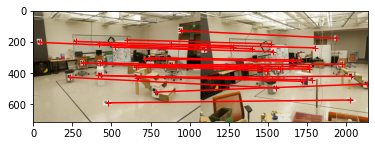

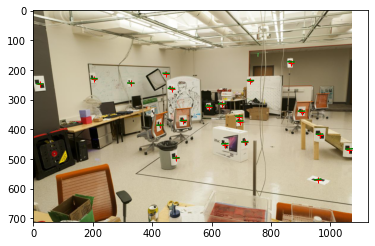

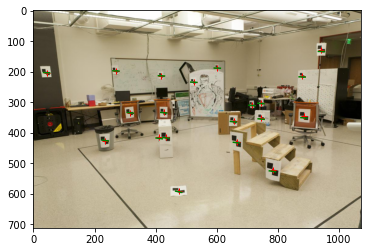

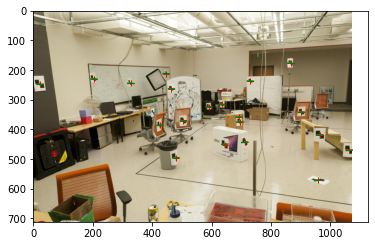

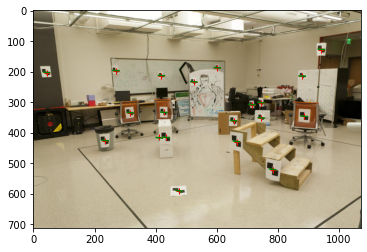

In [12]:
# Fundamental matrix estimation
name = 'lab' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print("F: ", F)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig("1")
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig("2")

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print("F: ", F)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig("3")
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig("4")

#### Part (2)

In [13]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(pts_3d, pts_2d):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    A = []
    for i in range(len(pts_3d)):
        x, y, z = pts_3d[i, 0], pts_3d[i, 1], pts_3d[i, 2]
        u, v = pts_2d[i, 0], pts_2d[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )

    A = np.asarray(A) 

    U, S, V = np.linalg.svd(A)
    L = V[-1, :] 
    H = L.reshape(3, 4)
    return H


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:,:2])
lab2_proj = camera_calibration(pts_3d, matches[:,2:])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:,:2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, matches[:,2:], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[ 3.09963996e-03  1.46204548e-04 -4.48497465e-04 -9.78930678e-01]
 [ 3.07018252e-04  6.37193664e-04 -2.77356178e-03 -2.04144405e-01]
 [ 1.67933533e-06  2.74767684e-06 -6.83964827e-07 -1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.545832902721848
residual in lab2: 15.544953451380152


In [14]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [15]:
# Write your code here for computing camera centers
def calc_camera_center(P):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    M = P[0:3,0:3]

    R, Q = scipy.linalg.rq(M)
    K = R/float(R[2,2])

    if K[0,0] < 0:
        K[:,0] = -1*K[:,0]
        Q[0,:] = -1*Q[0,:]

    if K[1,1] < 0:
        K[:,1] = -1*K[:,1]
        Q[1,:] = -1*Q[1,:]

    P_3_3 = np.dot(K,Q)
    P_proper_scale = (P_3_3[0,0]*P)/float(P[0,0])
    t = np.dot(np.linalg.inv(K), P_proper_scale[:,3])
    C = np.dot(-1*Q.T, t)
    return C

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243]
lab2 camera center [303.10003925 307.18428016  30.42166874]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


#### Part (4)

In [17]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(pt1, pt2, proj1, proj2):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    num_match = pt1.shape[0]
    kp1 = np.concatenate((pt1, np.ones((num_match, 1))), axis=1)
    kp2 = np.concatenate((pt2, np.ones((num_match, 1))), axis=1)
    P1 = proj1
    P2 = proj2
    
    # Reconstruct 3D coordinates
    X = np.zeros((num_match, 4))
    for i in range(num_match):
        xi1 = np.array([[0, -kp1[i, 2], kp1[i, 1]],
                        [kp1[i, 2], 0, -kp1[i, 0]],
                        [-kp1[i, 1], kp1[i, 0], 0]])
        xi2 = np.array([[0, -kp2[i, 2], kp2[i, 1]],
                        [kp2[i, 2], 0, -kp2[i, 0]],
                        [-kp2[i, 1], kp2[i, 0], 0]])  
        
        A1 = np.matmul(xi1, P1)
        A2 = np.matmul(xi2, P2)
        A = np.vstack((A1, A2))

        _, _, V = np.linalg.svd(A)
        temp = V[len(V)-1]
        X[i] = temp / temp[-1]
    print(X)
    return X

def evaluate_points_3d(p1, p2):
    """
    write your code to evaluate the triangulated 3D points
    """
    dist = 0
    for i in range(len(p1)):
        dist += np.linalg.norm(p1[i] - p2[i])
    return dist / len(p1)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
lab_pt1 = matches_lab[:,:2]
lab_pt2 = matches_lab[:,2:]
points_3d_gt = np.loadtxt('./lab_3d.txt')
points_3d_lab = triangulation(lab_pt1, lab_pt2, lab1_proj, lab2_proj) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_gt, points_3d_lab) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, lab_pt1, points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, lab_pt2, points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')
fig.savefig("5")

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
lib_pt1 = matches_lib[:,:2]
lib_pt2 = matches_lib[:,2:]
points_3d_lib = triangulation(lib_pt1, lib_pt2, lib1_proj, lib2_proj) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, lib_pt1, points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, lib_pt2, points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')
fig.savefig("6")

[[312.78880879 309.15417641  30.08907978   1.        ]
 [305.79512098 311.65275412  30.35670655   1.        ]
 [307.70149377 312.37111894  30.41570489   1.        ]
 [310.13097255 307.18073861  29.30161803   1.        ]
 [311.92827049 310.11304739  29.22222625   1.        ]
 [311.23190681 307.5741247   30.67829821   1.        ]
 [307.10487288 306.87906685  28.65986822   1.        ]
 [309.27730661 312.44121321  30.23120632   1.        ]
 [307.43489231 310.14362018  29.31610931   1.        ]
 [308.24019604 306.29704296  28.88677276   1.        ]
 [306.63911907 309.29280228  28.91056615   1.        ]
 [308.0650817  306.83731747  29.19213562   1.        ]
 [309.6279127  308.809221    29.03936286   1.        ]
 [308.26685123 309.96675775  29.26229699   1.        ]
 [307.57502104 308.62197333  28.95736672   1.        ]
 [311.05307213 309.20228909  28.9007626    1.        ]
 [307.5243652  308.18466078  29.0651996    1.        ]
 [309.93385516 311.25305349  29.99213554   1.        ]
 [312.2037

ValueError: operands could not be broadcast together with shapes (3,) (4,) 